In [1]:
import numpy as np
import pandas as pd
import os
from utils import get_label, load_data, preprocess_dataframe, get_tuner, save_model, load_model, print_scores, visualize_loss_curve
from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import LabelEncoder
import ydata_profiling as ydp
from sklearn.pipeline import Pipeline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
train_df, test_df = load_data()
label = get_label()

In [4]:
input_features = train_df.columns.tolist()
input_features.remove('PassengerId')
input_features.remove('Cabin')
input_features.remove('Parch')
input_features.remove('SibSp')
input_features.remove('Name')
input_features.remove('Ticket')
input_features.remove(label)
input_features

['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']

In [5]:
from sklearn.preprocessing import OneHotEncoder


X_train, y_train, X_val, y_val = preprocess_dataframe(
    train_df,
    input_features=input_features,
    drop_na=False,
    fill_na=True,
    enable_categorical=False,
    encoder=OneHotEncoder(sparse_output=False),
    drop_duplicates=True,
)
X_test = preprocess_dataframe(
    test_df,
    input_features=input_features,
    drop_na=False,
    fill_na=True,
    enable_categorical=False,
    test_split=None,
    encoder=OneHotEncoder(sparse_output=False),
)

X_train.head(5)

Converting Pclass to label
Converting Sex to label
Converting Embarked to label
Converting Pclass to label
Converting Sex to label
Converting Embarked to label


,Pclass,Sex,Age,Fare,Embarked,Has_Sibsp,Has_Parch,Has_Family
331,1.0,0.0,1.108483,-0.078684,0.0,0,0,0
733,0.0,0.0,-0.450254,-0.377145,0.0,0,0,0
382,0.0,0.0,0.173241,-0.474867,0.0,0,0,0
704,0.0,0.0,-0.242423,-0.476230,0.0,1,0,1
813,0.0,1.0,-1.627967,-0.025249,0.0,1,1,1


In [6]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=[16, 64, 16],
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=1e-3,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=10,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=True,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    # max_fun=15000,
)

In [7]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Sibsp', 'Has_Parch',
       'Has_Family'],
      dtype='object')

In [8]:
feature_subset = ['Sex', 'Age', 'Fare', 'Has_Family']
mlp_clf.fit(X_train[feature_subset], y_train)

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=[16, 64, 16], random_state=10)

In [9]:
print_scores(mlp_clf, X_train[feature_subset],
             y_train, X_val[feature_subset], y_val)

Train Score: 0.7567567567567568
Val score: 0.7039106145251397


(0.7567567567567568, 0.7039106145251397)

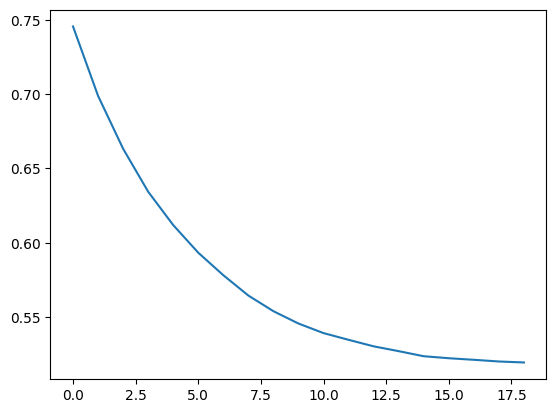

In [10]:
visualize_loss_curve(mlp_clf.loss_curve_)

In [12]:
hparam_grid = {
    'classifier__hidden_layer_sizes': [[16, 128, 16], [16, 128, 128, 16], [16, 64, 128, 64, 16]],
    'classifier__activation': ['tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001],
    'classifier__batch_size': ['auto'],
    'classifier__learning_rate': ['constant'],
    'classifier__learning_rate_init': [5e-3, 1e-3, 3e-3],
    'classifier__power_t': [0.5],
    'classifier__max_iter': [200],
    'classifier__shuffle': [True],
    'classifier__random_state': [None, 7, 10, 42],
    'classifier__tol': [0.0001],
    'classifier__warm_start': [True],
    # 'classifier__momentum': [0.9],
    # 'classifier__nesterovs_momentum': [True],
    'classifier__early_stopping': [True],
    'classifier__validation_fraction': [0.1, 0.2],
    'classifier__beta_1': [0.9],
    'classifier__beta_2': [0.999],
    # 'classifier__epsilon': [1e-08],
    'classifier__n_iter_no_change': [10],
}
mlp_pipeline = Pipeline([('classifier', MLPClassifier())])
tuner = get_tuner(mlp_pipeline, hparam_grid)

In [13]:
tuner.fit(X_train[feature_subset], y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', MLPClassifier())]),
             param_grid={'classifier__activation': ['tanh'],
                         'classifier__alpha': [0.0001],
                         'classifier__batch_size': ['auto'],
                         'classifier__beta_1': [0.9],
                         'classifier__beta_2': [0.999],
                         'classifier__early_stopping': [True],
                         'classifier__hidden_layer_sizes': [[16, 128, 16],
                                                            [16, 128, 128, 16],
                                                            [16, 64, 128...
                         'classifier__learning_rate_init': [0.005, 0.001,
                                                            0.003],
                         'classifier__max_iter': [200],
                         'classifier__n_iter_no_change': [10],
                         'classifier__power_t': [0.5],
                         'classifier__random_state': [None, 7, 10, 42],
                         'classifier__shuffle': [True],
                         'classifier__solver': ['adam', 'sgd'],
                         'classifier__tol': [0.0001],
                         'classifier__validation_fraction': [0.1, 0.2],
                         'classifier__warm_start': [True]},
             return_train_score=True)

In [14]:
tuner.best_estimator_.get_params()['classifier']

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=[16, 128, 16], learning_rate_init=0.003,
              random_state=42, validation_fraction=0.2, warm_start=True)

In [15]:
print_scores(tuner.best_estimator_,
             X_train[feature_subset], y_train, X_val[feature_subset], y_val)

Train Score: 0.7672672672672672
Val score: 0.7653631284916201


(0.7672672672672672, 0.7653631284916201)

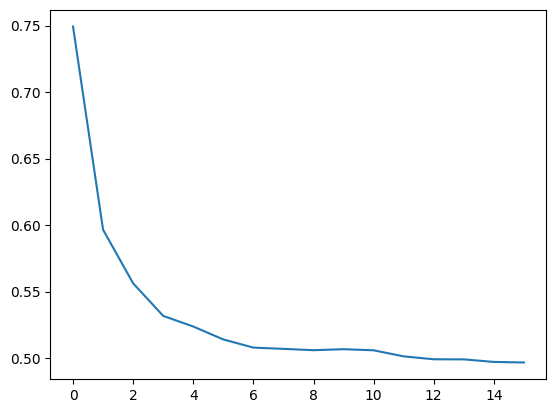

In [16]:
visualize_loss_curve(tuner.best_estimator_.get_params()
                     ['classifier'].loss_curve_)

In [40]:
# save if outperforms the best model
# save_model(tuner.best_estimator_, 'mlp_train_083_val_080')

# Best Model so far

In [42]:
best_model = load_model('mlp_train_083_val_080')

In [43]:
best_model.get_params()['classifier']

MLPClassifier(activation='tanh', hidden_layer_sizes=[16, 32, 16],
              warm_start=True)

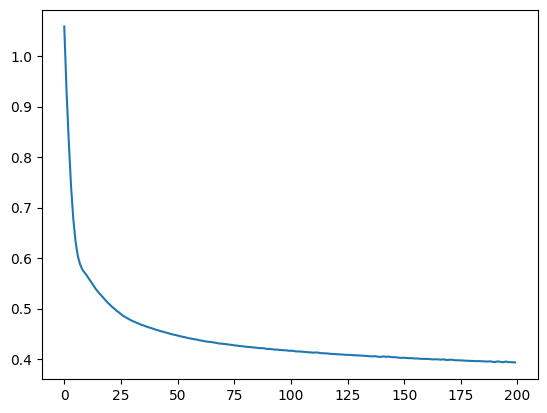

In [60]:
visualize_loss_curve(best_model.get_params()['classifier'].loss_curve_)